# Directory Classifier
Note: Accuracy results vary with split in the data. The best one I've found so far is 80%.

Christoph Uhl, last edited: 02/21/19

In [1]:
%matplotlib inline
import IPython.core.display     
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sklearn as sk
from sklearn import naive_bayes, ensemble
from scipy import stats
np.random.seed(100)

from bs4 import BeautifulSoup, Comment
import nltk as nl

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Set up an easy way to import the data.

In [2]:
def getAllData():
    categoryData = [] #will be populated with tuples of form (category, htmlString)
    with open('training_data.txt') as file: #hardcoded the file name, since this is a pretty specific way for data retrieval
        file.readline()
        for line in file.readlines():
            #(classID, htmlName) = line.split("\t")
            splitter = line.split("\t")
            filename = splitter[1][:len(splitter[1])-1] #splitter[1] gives the filename with a \n at the end, so get rid of that
            doc = getSpecificData("html/" + filename) 
            #splitter is already in a convenient tuple form where index=0 gives the category, 
            #now just turn the second part into the actual data
            splitter[1] = doc 
            categoryData.append(splitter)
    return categoryData

def getSpecificData(filename):
    #function to get the training data documents and help arrange them in a way sklearn can use them.
    
    # i need to come up with some way that I can represent the html to sklearn. We need to put it in form of a vector.
    #if the html file contains certain types of words, the I want to represent that. etc. etc.
    with open(filename) as document:
        document.readline()
        soup = BeautifulSoup(document.read(), 'html')
        [s.extract() for s in soup.find_all(['head','link', 'script', 'meta', 'style', 'button'])]
        comments = soup.findAll(text=lambda text:isinstance(text, Comment))
        [comment.extract() for comment in comments]
        return str(soup)
    
    

In [3]:
# # Now get the data..
# myData = getAllData()

I wrote the above functions in the beginning, thinking that I could just get all of the html data and throw it at sklearn. This did not work out well at all (lower accuracy than always guessing class=0). So I decided I should go simpler. 

Let's start out by just using title data. Note that some webpages did not give titles, and so I simply return an empty string for those. That means the classifier built purely on the title data, will not be able to correctly identify all directory webpages. Of course, this will need to get fixed, but for now let's stay simple.

In [4]:
#creating an easy way to get all title day
def getAllTitleData():
    X = [] #the data vector (this function fills it with strings)
    y = [] #the class vector
    with open('training_data.txt') as file: #hardcoded the file name, since this is a pretty specific way for data retrieval
        file.readline() #skip the first line as it only provides information helpful for humans
        for line in file.readlines():
            category, filename = line.split("\t")
            filename = filename[:len(filename)-1] #splitter[1] gives the filename with a \n at the end, so get rid of that
            X.append(getTitleData("html/" + filename))
            y.append(category)
    return X, y

def getTitleData(filename):
    #function to take only the title of an html page.
    with open(filename) as document:
        document.readline()
        soup = BeautifulSoup(document.read(), 'html')
        try: return str(soup.title.string)
        except: return ""
        ## Some other code for future reference.
#         [s.extract() for s in soup.find_all(['script', 'style'])]
#         text = str(soup.get_text())
    

In [5]:
#this function was built simply to facilitate understanding of which parsing works well and which doesn't 
def printRaw(filename):
    with open(filename) as file:
        print(file.read())
    return

In [6]:
# Get the title data!
X,y = getAllTitleData()

In [7]:
#check if it works
print(y[1], X[1])

1 Faculty & Advisors | MIT EECS


In [8]:
## Considered using nltk. Perhaps in the future?

# specificPage = getSpecificData("html/1.html")
# tokenize.word_tokenize(specificPage)

Now that we have the data, separate it. This is what causes differences in accuracy scores below.

In [27]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.20)

So the thing with our data is that a large majority of classes are 0 (i.e. not a directory). This means that if I just make an array of zeros, I correctly predict the right class with 90% accuracy:

In [28]:
literally_just_zeros = np.zeros(len(y_test), int).astype(str)
print(sk.metrics.accuracy_score(y_test, literally_just_zeros))

0.9011764705882352


Now, the goal is to get a high accuracy in the correctly identified directories. So for now, when evaluating, let's just look at the correctly predicted directories (class = 1). Here, I define my personal evaluation function:

In [29]:
#this function expects both parameters to be lists of strings.
#it returns a tuple (totalAcc, onesAcc)
def specialized_accuracy(truth, pred):
    length = len(truth)
    num_ones = 0
    if length != len(pred): raise Exception('Arguments do not have the same length.')
    grossCounter = 0
    correctOnes = 0
    for i, val in enumerate(truth):
        int_val = int(val)
        num_ones += int_val #if val == '0', then we don't want to add anything, if it's '1' however, we do.
        if pred[i] == val: 
            grossCounter += 1
            correctOnes += int_val #only add to correctOnes if it was corectly predicted.
    return (grossCounter/length, correctOnes/num_ones)

And it works correctly:

In [30]:
print("For just zeros:", specialized_accuracy(y_test, literally_just_zeros))
print("For just ones:", specialized_accuracy(y_test, np.ones(len(y_test), int).astype(str)))

For just zeros: (0.9011764705882352, 0.0)
For just ones: (0.0988235294117647, 1.0)


#### Bag of Words:

In [31]:
count_vect50 = sk.feature_extraction.text.CountVectorizer(stop_words="english", max_features=50)
X_train_counts50 = count_vect50.fit_transform(X_train)
X_test_counts50 = count_vect50.transform(X_test)

count_vect100 = sk.feature_extraction.text.CountVectorizer(stop_words="english", max_features=100)
X_train_counts100 = count_vect100.fit_transform(X_train)
X_test_counts100 = count_vect100.transform(X_test)

count_vect150 = sk.feature_extraction.text.CountVectorizer(stop_words="english", max_features=150)
X_train_counts150 = count_vect150.fit_transform(X_train)
X_test_counts150 = count_vect150.transform(X_test)

count_vect200 = sk.feature_extraction.text.CountVectorizer(stop_words="english", max_features=150)
X_train_counts200 = count_vect200.fit_transform(X_train)
X_test_counts200 = count_vect200.transform(X_test)

In [32]:
#****** Got this function from my Machine Learning professor ******#
# define a function for prettier output. 
def showVocab(vocab, counts=None):
    #print out the vocabulary. if counts specified, then only print the words w/ non-zero entries
    allwords = list(vocab.keys())
    allwords.sort()  # sort vocabulary by index
    wordlist = []
    for word in allwords:
        ind = vocab[word]
        if (counts is None):
            mystr = "{:3d}. {}".format(ind, word)
        elif (counts[0,ind]>0):
            mystr = "{:3d}. ({:0.4f}) {}".format(ind, counts[0,ind], word)
        else:
            continue  # skip it
        wordlist.append(mystr)

    # print 2 columns
    it = iter(wordlist)
    for i in it:
        print('{:<30}{}'.format(i, next(it)))

In [33]:
showVocab(count_vect50.vocabulary_)

  0. admissions                 1. alumni
  2. applied                    3. calendar
  4. campus                     5. carolina
  6. center                     7. college
  8. colorado                   9. computer
 10. computing                 11. cs
 12. degree                    13. department
 14. directory                 15. electrical
 16. engineering               17. events
 18. faculty                   19. george
 20. georgia                   21. graduate
 22. home                      23. illinois
 24. information               25. institute
 26. maine                     27. missouri
 28. new                       29. news
 30. office                    31. ottawa
 32. program                   33. programs
 34. research                  35. resources
 36. school                    37. science
 38. sciences                  39. services
 40. south                     41. staff
 42. state                     43. student
 44. students                  45. technology
 46.

## Naive Bayes

Starting out with Bernoulli Naive Bayes. The alpha value adds Laplace smoothing (i.e. adding probability to words that actually never happened in the training set, at the expense of the probability of those words that did happen)

First only use 50 features.

In [34]:
zero_bmodel = naive_bayes.BernoulliNB(alpha=0.0)
zero_bmodel.fit(X_train_counts50, y_train) #fit the model with a list with all the trained document vectors and the corresponding category vector
predY = zero_bmodel.predict(X_test_counts50)
print("--- ALPHA = 0.0 ---")
zerob_accuracy = specialized_accuracy(y_test, predY)
print(zerob_accuracy)

#letting alpha=0.05
twenty_bmodel = naive_bayes.BernoulliNB(alpha=0.05)
twenty_bmodel.fit(X_train_counts50, y_train)
predY = twenty_bmodel.predict(X_test_counts50)
print("--- ALPHA = 0.05 ---")
twentyb_accuracy = specialized_accuracy(y_test, predY)
print(twentyb_accuracy)

#letting alpha=0.1
one_bmodel = naive_bayes.BernoulliNB(alpha=0.1)
one_bmodel.fit(X_train_counts50, y_train)
predY = one_bmodel.predict(X_test_counts50)
print("--- ALPHA = 0.1 ---")
oneb_accuracy = specialized_accuracy(y_test, predY)
print(oneb_accuracy)

#letting alpha=0.2
two_bmodel = naive_bayes.BernoulliNB(alpha=0.2)
two_bmodel.fit(X_train_counts50, y_train)
predY = two_bmodel.predict(X_test_counts50)
print("--- ALPHA = 0.2 ---")
twob_accuracy = specialized_accuracy(y_test, predY)
print(twob_accuracy)


--- ALPHA = 0.0 ---
(0.9176470588235294, 0.5238095238095238)
--- ALPHA = 0.05 ---
(0.9176470588235294, 0.5238095238095238)
--- ALPHA = 0.1 ---
(0.9176470588235294, 0.5238095238095238)
--- ALPHA = 0.2 ---
(0.9176470588235294, 0.5238095238095238)


/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Now let's look at 100 features:

In [35]:
zero_bmodel = sk.naive_bayes.BernoulliNB(alpha=0.0)
zero_bmodel.fit(X_train_counts100, y_train) #fit the model with a list with all the trained document vectors and the corresponding category vector
predY = zero_bmodel.predict(X_test_counts100)
print("--- ALPHA = 0.0 ---")
zerob_accuracy = specialized_accuracy(y_test, predY)
print(zerob_accuracy)

#letting alpha=0.05
twenty_bmodel = sk.naive_bayes.BernoulliNB(alpha=0.05)
twenty_bmodel.fit(X_train_counts100, y_train)
predY = twenty_bmodel.predict(X_test_counts100)
print("--- ALPHA = 0.05 ---")
twentyb_accuracy = specialized_accuracy(y_test, predY)
print(twentyb_accuracy)

#letting alpha=0.1
one_bmodel = sk.naive_bayes.BernoulliNB(alpha=0.1)
one_bmodel.fit(X_train_counts100, y_train)
predY = one_bmodel.predict(X_test_counts100)
print("--- ALPHA = 0.1 ---")
oneb_accuracy = specialized_accuracy(y_test, predY)
print(oneb_accuracy)

#letting alpha=0.2
two_bmodel = sk.naive_bayes.BernoulliNB(alpha=0.2)
two_bmodel.fit(X_train_counts100, y_train)
predY = two_bmodel.predict(X_test_counts100)
print("--- ALPHA = 0.2 ---")
twob_accuracy = specialized_accuracy(y_test, predY)
print(twob_accuracy)


--- ALPHA = 0.0 ---
(0.92, 0.5476190476190477)
--- ALPHA = 0.05 ---
(0.9247058823529412, 0.5952380952380952)
--- ALPHA = 0.1 ---
(0.9247058823529412, 0.5952380952380952)
--- ALPHA = 0.2 ---
(0.9247058823529412, 0.5952380952380952)


/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Finally looking at 150 features

In [36]:
zero_bmodel = sk.naive_bayes.BernoulliNB(alpha=0.0)
zero_bmodel.fit(X_train_counts150, y_train) #fit the model with a list with all the trained document vectors and the corresponding category vector
predY = zero_bmodel.predict(X_test_counts150)
print("--- ALPHA = 0.0 ---")
zerob_accuracy = specialized_accuracy(y_test, predY)
print(zerob_accuracy)

#letting alpha=0.05
twenty_bmodel = sk.naive_bayes.BernoulliNB(alpha=0.05)
twenty_bmodel.fit(X_train_counts150, y_train)
predY = twenty_bmodel.predict(X_test_counts150)
print("--- ALPHA = 0.05 ---")
twentyb_accuracy = specialized_accuracy(y_test, predY)
print(twentyb_accuracy)

#letting alpha=0.1
one_bmodel = sk.naive_bayes.BernoulliNB(alpha=0.1)
one_bmodel.fit(X_train_counts150, y_train)
predY = one_bmodel.predict(X_test_counts150)
print("--- ALPHA = 0.1 ---")
oneb_accuracy = specialized_accuracy(y_test, predY)
print(oneb_accuracy)

#letting alpha=0.2
two_bmodel = sk.naive_bayes.BernoulliNB(alpha=0.2)
two_bmodel.fit(X_train_counts150, y_train)
predY = two_bmodel.predict(X_test_counts150)
print("--- ALPHA = 0.2 ---")
twob_accuracy = specialized_accuracy(y_test, predY)
print(twob_accuracy)


--- ALPHA = 0.0 ---
(0.9176470588235294, 0.5)
--- ALPHA = 0.05 ---
(0.9247058823529412, 0.5714285714285714)
--- ALPHA = 0.1 ---
(0.9270588235294117, 0.5952380952380952)
--- ALPHA = 0.2 ---
(0.9270588235294117, 0.5952380952380952)


/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


The accuracies are surprisingly good, given that this is based purely on webpage titles. But perhaps other models can do better.

Before that, though, let's see if the Bernoulli Naive Bayes Classifier does any better with TF-IDF representation. The best feature size was 100, so sticking with it for now.

In [37]:
tf_trans = sk.feature_extraction.text.TfidfTransformer(use_idf=True)
Xtf_train_counts = tf_trans.fit_transform(X_train_counts100)
Xtf_test_counts = tf_trans.transform(X_test_counts100)

In [38]:
zerotf_bmodel = sk.naive_bayes.BernoulliNB(alpha=0.0)
zerotf_bmodel.fit(Xtf_train_counts, y_train) #fit the model with a list with all the trained document vectors and the corresponding category vector
predY = zerotf_bmodel.predict(Xtf_test_counts)
print("--- ALPHA = 0.0 ---")
zerobtf_accuracy = specialized_accuracy(y_test, predY)
print(zerobtf_accuracy)

#letting alpha=0.05
twentytf_bmodel = sk.naive_bayes.BernoulliNB(alpha=0.05)
twentytf_bmodel.fit(Xtf_train_counts, y_train)
predY = twentytf_bmodel.predict(Xtf_test_counts)
print("--- ALPHA = 0.05 ---")
twentybtf_accuracy = specialized_accuracy(y_test, predY)
print(twentybtf_accuracy)

#letting alpha=0.1
onetf_bmodel = sk.naive_bayes.BernoulliNB(alpha=0.1)
onetf_bmodel.fit(Xtf_train_counts, y_train)
predY = onetf_bmodel.predict(Xtf_test_counts)
print("--- ALPHA = 0.1 ---")
onebtf_accuracy = specialized_accuracy(y_test, predY)
print(onebtf_accuracy)

#letting alpha=0.2
twotf_bmodel = sk.naive_bayes.BernoulliNB(alpha=0.2)
twotf_bmodel.fit(Xtf_train_counts, y_train)
predY = twotf_bmodel.predict(Xtf_test_counts)
print("--- ALPHA = 0.2 ---")
twobtf_accuracy = specialized_accuracy(y_test, predY)
print(twobtf_accuracy)


/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


--- ALPHA = 0.0 ---
(0.92, 0.5476190476190477)
--- ALPHA = 0.05 ---
(0.9247058823529412, 0.5952380952380952)
--- ALPHA = 0.1 ---
(0.9247058823529412, 0.5952380952380952)
--- ALPHA = 0.2 ---
(0.9247058823529412, 0.5952380952380952)


No difference at all. I wonder if I did something wrong..

For now, let's not worry about it too much, and move on to:

### Random Forest

Since it worked so well for the Bernoulli Naive Bayes, let's try using 100 features with a basic, 10 estimators random forest classifier:

In [39]:
def randForest(trainFeatures, testFeatures, random_state = 3104, estimators = 10):
    rf = ensemble.RandomForestClassifier(random_state=random_state, n_estimators=estimators)
    rf.fit(trainFeatures, y_train)
    predY = rf.predict(testFeatures)
    acc = specialized_accuracy(y_test, predY)
    return acc

In [40]:
def getAvgAcc(train, test, estimators = 10):
    avgGrossAcc = 0
    avgOneAcc = 0
    ranger = np.arange(3022, 3104)
    for random_state in ranger: 
        acc = randForest(train, test, random_state, estimators)
        avgGrossAcc += acc[0]
        avgOneAcc += acc[1]

    n = len(ranger)
    print("Average accuracy:", (avgGrossAcc/n, avgOneAcc/n))
    return

In [41]:
getAvgAcc(X_train_counts100, X_test_counts100)

Average accuracy: (0.9724820659971303, 0.7534843205574913)


Let's see what happens if we try 150 features.

In [42]:
getAvgAcc(X_train_counts150, X_test_counts150)

Average accuracy: (0.9700143472022953, 0.7296747967479673)


Let's try it with 50 and 200 features now too, why not.

In [43]:
print("50 features:")
getAvgAcc(X_train_counts50, X_test_counts50)
print("200 features:")
getAvgAcc(X_train_counts200, X_test_counts200)

50 features:
Average accuracy: (0.9637589670014349, 0.6489547038327531)
200 features:
Average accuracy: (0.9700143472022953, 0.7296747967479673)


It doesn't change much at all. It really seems that 100 features is the best. [Edit: re-running the entire kernel gives a different split in the data, which results in different outcomes. I didn't think the difference would be so significant, but it seems that it is.]

Let's stick with 100 features, and move on to trying some more trees in the forest. This may take a while..

In [44]:
getAvgAcc(X_train_counts100, X_test_counts100, 10)
getAvgAcc(X_train_counts100, X_test_counts100, 25)
getAvgAcc(X_train_counts100, X_test_counts100, 50)
getAvgAcc(X_train_counts100, X_test_counts100, 75)
getAvgAcc(X_train_counts100, X_test_counts100, 100)

Average accuracy: (0.9724820659971303, 0.7534843205574913)
Average accuracy: (0.9740315638450494, 0.772648083623693)
Average accuracy: (0.9746628407460538, 0.7790360046457605)
Average accuracy: (0.9746915351506451, 0.7790360046457608)
Average accuracy: (0.9748350071736005, 0.7801974448315911)


Okay, so it seems that the best one uses as many estimators as possible, let's check that. In the future, I should definitely just use cross-validation.

In [45]:
getAvgAcc(X_train_counts100, X_test_counts100, 150)

Average accuracy: (0.9750932568149207, 0.7816492450638793)


In [46]:
getAvgAcc(X_train_counts100, X_test_counts100, 200)

Average accuracy: (0.975523672883787, 0.7871660859465737)


In [47]:
getAvgAcc(X_train_counts100, X_test_counts100, 300)

Average accuracy: (0.9755523672883784, 0.7891986062717767)


In [48]:
getAvgAcc(X_train_counts100, X_test_counts100, 500)

Average accuracy: (0.9756958393113341, 0.7900696864111497)


Ok, a forest of 500 trees takes forever to run and only gives marginal improvement. Let's not do more..

Accuracy = (0.9764705882352941, 0.8095238095238095)
Confusion matrix, without normalization
[[381   8]
 [  2  34]]
Normalized confusion matrix
[[0.98 0.02]
 [0.06 0.94]]


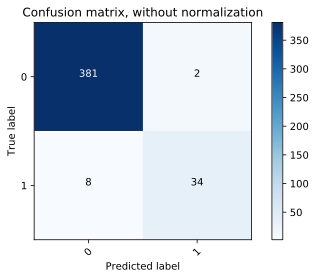

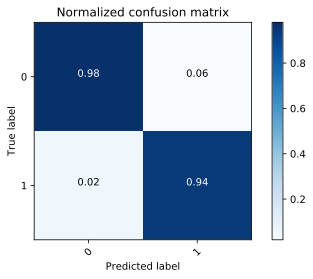

In [61]:
#from sklearns webpage: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with

class_names = ['0', '1']

rf = ensemble.RandomForestClassifier(random_state=3104, n_estimators=200)
rf.fit(X_train_counts100, y_train)
y_pred = rf.predict(X_test_counts100)
print("Accuracy =", specialized_accuracy(y_test, y_pred))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_pred, y_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()